In [5]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
#import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Dataset

In [6]:
TRAIN_PATH="DRIVE/training/"
TEST_PATH="DRIVE/test/"

In [7]:
train_ids=next(os.walk(TRAIN_PATH+'images/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'images/'))[2][:]
print(len(train_ids))

20


In [8]:
input_height = IMG_HEIGHT = 256
input_width = IMG_WIDTH = 256
IMG_CHANNELS = 3

In [9]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

Resizing training images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_17968\2743126915.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.36it/s]


Resizing test images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_17968\2743126915.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.35it/s]


In [10]:
print(X_train.shape, Y_test.shape)

(20, 256, 256, 3) (20, 256, 256, 1)


C:\Users\manda\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


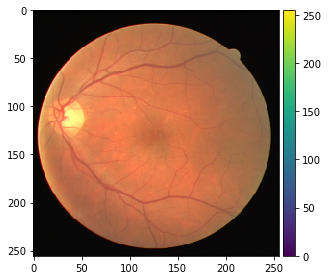

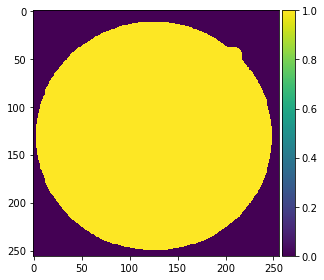

In [11]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

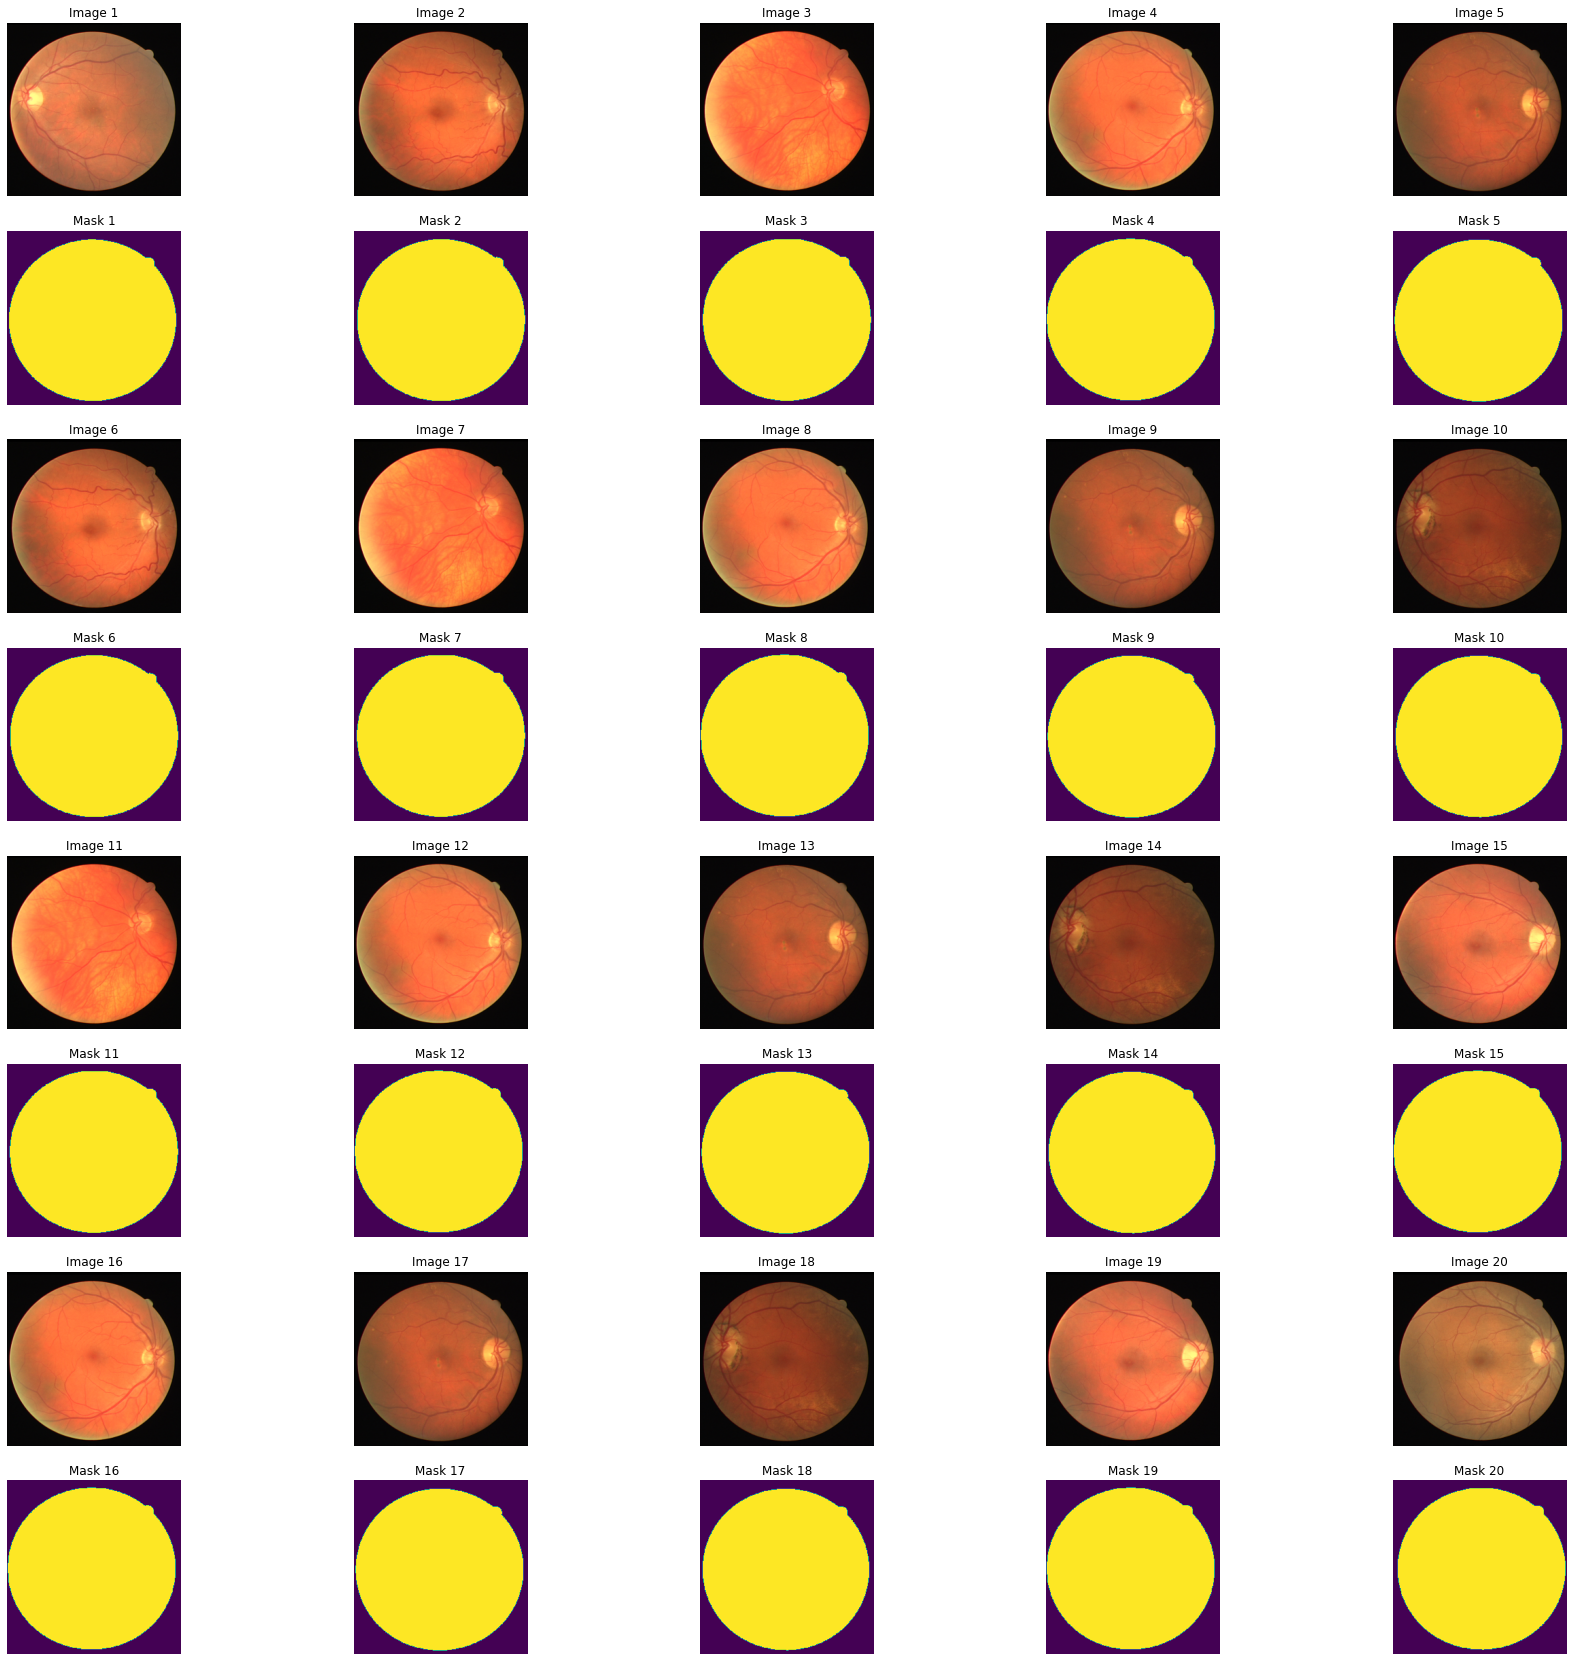

In [12]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

# Model

In [13]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

# Complete model

In [14]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
#s = inputs
x, skip_1 = encoder(s)
x = bottleneck(x)
x = decoder(x, skip_1)
outputs = output(x)
model = Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 16  91         ['rescaling[0][0]']              
 v2D)                           )                                                                 
                                                                                              

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 64)  256         ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 64)   2112        ['max_pooling2d_1[0][0]']        
                                                                                                  
 activation_5 (Activation)      (None, 64, 64, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 64, 64, 64)  256         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
          

 activation_10 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 separable_conv2d_11 (Separable  (None, 32, 32, 128)  17664      ['activation_10[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 32, 32, 128)  512        ['separable_conv2d_11[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 128)  49280       ['concatenate[0][0]']            
                                                                                                  
 activatio

                                                                                                  
 add_7 (Add)                    (None, 128, 128, 32  0           ['batch_normalization_23[0][0]', 
                                )                                 'dropout_7[0][0]']              
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 256, 256, 32  0          ['add_7[0][0]']                  
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 48  0           ['up_sampling2d_3[0][0]',        
                                )                                 'add[0][0]']                    
                                                                                                  
 separable

# Metrics

In [16]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    #print('IOU {}'.format(iou))
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1-tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    #loss = -tf.map_fn(my_iou_metric_loss(label, pred), tf.range(tf.shape(pred)[0]))
    loss.set_shape((None,))

    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    return hausdorff_distance(y_true,y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape)==2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd/batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt,pred,target_size=(256,256),flag_multi_class = False,num_class = 2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
    
    hd = haud_dist_batch(gt,pred)
    
    miou = iou_metric_batch(gt,pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    print("Accuracy=",r_acc, "Precision=",r_pr, "Recall=",r_rc, "MeanIoU=",r_mi, "DiceCoefficient=",dc, "HD=",hd, "MyIoU=",miou, "MAE=",r_mae)

# Loss

In [17]:
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

# Callbacks

In [20]:
log_path = "logs/"
keyname = "Unet-without-BT"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

# Training

In [21]:
TRAIN_FLG = 1 # 0 - No Training, 1 - Training
val_split = 0.3
model.compile(
    loss=bce_dice_loss,
    optimizer=Adam(),
    metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_haud_dist, my_iou_metric]
   )
if TRAIN_FLG:
    print("Training")
    callbacks = [
        model_checkpoint,
        reduce_lr,
        csv_logger,
        tensorboard_callback,
        early_stopping
    ]
    X_train_20 = X_train[:int(X_train.shape[0]*0.2)]
    Y_train_20 = Y_train[:int(Y_train.shape[0]*0.2)]
    results = model.fit(X_train_20, Y_train_20, validation_split=val_split, batch_size=8, epochs=200, callbacks=callbacks)
elif not TRAIN_FLG:
    print("Loading training weights")
    model.load_weights('model_'+keyname+'.hdf5')

Training
Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.2973 - precision_1: 0.5047 - mean_io_u_1: 0.1466 - recall_1: 0.3072 - dice_coeff: 0.5208 - mean_absolute_error: 0.5730 - my_haud_dist: 8.6991 - my_iou_metric: 0.0000e+00
Epoch 1: loss improved from inf to 0.28754, saving model to model_Unet-without-BT.hdf5
1/1 [==============================] - 16s 16s/step - loss: 0.2875 - accuracy: 0.2973 - precision_1: 0.5047 - mean_io_u_1: 0.1466 - recall_1: 0.3072 - dice_coeff: 0.5208 - mean_absolute_error: 0.5730 - my_haud_dist: 8.6991 - my_iou_metric: 0.0000e+00 - val_loss: 0.1930 - val_accuracy: 0.7088 - val_precision_1: 0.7102 - val_mean_io_u_1: 0.1446 - val_recall_1: 0.9973 - val_dice_coeff: 0.6784 - val_mean_absolute_error: 0.4210 - val_my_haud_dist: 8.0926 - val_my_iou_metric: 0.3750 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.7026 - precision_1: 0.9198 - mean_io_u_1: 0.1466 - recall_1: 0.

Epoch 11/200
1/1 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9747 - precision_1: 0.9992 - mean_io_u_1: 0.1466 - recall_1: 0.9650 - dice_coeff: 0.7495 - mean_absolute_error: 0.3050 - my_haud_dist: 5.7019 - my_iou_metric: 0.0783
Epoch 11: loss improved from 0.15077 to 0.15028, saving model to model_Unet-without-BT.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1503 - accuracy: 0.9747 - precision_1: 0.9992 - mean_io_u_1: 0.1466 - recall_1: 0.9650 - dice_coeff: 0.7495 - mean_absolute_error: 0.3050 - my_haud_dist: 5.7019 - my_iou_metric: 0.0783 - val_loss: 0.0951 - val_accuracy: 0.7107 - val_precision_1: 0.7107 - val_mean_io_u_1: 0.1446 - val_recall_1: 1.0000 - val_dice_coeff: 0.8415 - val_mean_absolute_error: 0.2403 - val_my_haud_dist: 8.8276 - val_my_iou_metric: 0.0000e+00 - lr: 0.0010
Epoch 12/200
1/1 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9768 - precision_1: 0.9993 - mean_io_u_1: 0.1466 - recall_1: 0.9678 - d

Epoch 21/200
1/1 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9809 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9732 - dice_coeff: 0.7525 - mean_absolute_error: 0.3012 - my_haud_dist: 5.6043 - my_iou_metric: 0.1167
Epoch 21: loss improved from 0.14852 to 0.14852, saving model to model_Unet-without-BT.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1485 - accuracy: 0.9809 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9732 - dice_coeff: 0.7525 - mean_absolute_error: 0.3012 - my_haud_dist: 5.6043 - my_iou_metric: 0.1167 - val_loss: 0.1164 - val_accuracy: 0.7107 - val_precision_1: 0.7107 - val_mean_io_u_1: 0.1446 - val_recall_1: 1.0000 - val_dice_coeff: 0.8061 - val_mean_absolute_error: 0.2821 - val_my_haud_dist: 8.4274 - val_my_iou_metric: 0.0000e+00 - lr: 1.0000e-04
Epoch 22/200
1/1 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9816 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9742

Epoch 31/200
1/1 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9747 - dice_coeff: 0.7527 - mean_absolute_error: 0.3008 - my_haud_dist: 5.6035 - my_iou_metric: 0.1607
Epoch 31: loss did not improve from 0.14834
1/1 [==============================] - 1s 1s/step - loss: 0.1484 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9747 - dice_coeff: 0.7527 - mean_absolute_error: 0.3008 - my_haud_dist: 5.6035 - my_iou_metric: 0.1607 - val_loss: 0.1487 - val_accuracy: 0.7609 - val_precision_1: 0.7483 - val_mean_io_u_1: 0.1446 - val_recall_1: 1.0000 - val_dice_coeff: 0.7521 - val_mean_absolute_error: 0.3408 - val_my_haud_dist: 7.9653 - val_my_iou_metric: 0.0286 - lr: 1.0000e-05
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9820 - precision_1: 0.9998 - mean_io_u_1: 0.1466 - recall_1: 0.9746 - dice_coeff: 0.7528 - mean_absolute_error: 0.3008 

1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9748 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dist: 5.6316 - my_iou_metric: 0.2500
Epoch 41: loss improved from 0.14833 to 0.14832, saving model to model_Unet-without-BT.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9748 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dist: 5.6316 - my_iou_metric: 0.2500 - val_loss: 0.1721 - val_accuracy: 0.9646 - val_precision_1: 0.9563 - val_mean_io_u_1: 0.1446 - val_recall_1: 0.9957 - val_dice_coeff: 0.7132 - val_mean_absolute_error: 0.3794 - val_my_haud_dist: 7.7505 - val_my_iou_metric: 0.3917 - lr: 1.0000e-06
Epoch 42/200
1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9746 - dice_coeff: 0.

1/1 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9822 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9751 - dice_coeff: 0.7527 - mean_absolute_error: 0.3008 - my_haud_dist: 5.5796 - my_iou_metric: 0.1806
Epoch 51: loss did not improve from 0.14832
1/1 [==============================] - 1s 1s/step - loss: 0.1484 - accuracy: 0.9822 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9751 - dice_coeff: 0.7527 - mean_absolute_error: 0.3008 - my_haud_dist: 5.5796 - my_iou_metric: 0.1806 - val_loss: 0.1879 - val_accuracy: 0.9830 - val_precision_1: 0.9912 - val_mean_io_u_1: 0.1446 - val_recall_1: 0.9848 - val_dice_coeff: 0.6868 - val_mean_absolute_error: 0.4039 - val_my_haud_dist: 7.5378 - val_my_iou_metric: 0.7500 - lr: 1.0000e-07
Epoch 52/200
1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9747 - dice_coeff: 0.7528 - mean_absolute_error: 0.3008 - my_haud_dis

1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9821 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9750 - dice_coeff: 0.7528 - mean_absolute_error: 0.3008 - my_haud_dist: 5.6288 - my_iou_metric: 0.1833
Epoch 61: loss did not improve from 0.14832
1/1 [==============================] - 1s 1s/step - loss: 0.1483 - accuracy: 0.9821 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9750 - dice_coeff: 0.7528 - mean_absolute_error: 0.3008 - my_haud_dist: 5.6288 - my_iou_metric: 0.1833 - val_loss: 0.1988 - val_accuracy: 0.9812 - val_precision_1: 0.9993 - val_mean_io_u_1: 0.1446 - val_recall_1: 0.9741 - val_dice_coeff: 0.6687 - val_mean_absolute_error: 0.4199 - val_my_haud_dist: 7.3916 - val_my_iou_metric: 0.7500 - lr: 1.0000e-08
Epoch 62/200
1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9998 - mean_io_u_1: 0.1466 - recall_1: 0.9746 - dice_coeff: 0.7528 - mean_absolute_error: 0.3008 - my_haud_dis

1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9747 - dice_coeff: 0.7528 - mean_absolute_error: 0.3008 - my_haud_dist: 5.5967 - my_iou_metric: 0.1556
Epoch 71: loss did not improve from 0.14832
1/1 [==============================] - 1s 1s/step - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9747 - dice_coeff: 0.7528 - mean_absolute_error: 0.3008 - my_haud_dist: 5.5967 - my_iou_metric: 0.1556 - val_loss: 0.2066 - val_accuracy: 0.9766 - val_precision_1: 1.0000 - val_mean_io_u_1: 0.1446 - val_recall_1: 0.9671 - val_dice_coeff: 0.6557 - val_mean_absolute_error: 0.4309 - val_my_haud_dist: 7.2995 - val_my_iou_metric: 1.0000 - lr: 1.0000e-09
Epoch 72/200
1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9822 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9751 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dis

1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9822 - precision_1: 0.9998 - mean_io_u_1: 0.1466 - recall_1: 0.9750 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dist: 5.6074 - my_iou_metric: 0.2292
Epoch 81: loss did not improve from 0.14829
1/1 [==============================] - 1s 1s/step - loss: 0.1483 - accuracy: 0.9822 - precision_1: 0.9998 - mean_io_u_1: 0.1466 - recall_1: 0.9750 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dist: 5.6074 - my_iou_metric: 0.2292 - val_loss: 0.2123 - val_accuracy: 0.9732 - val_precision_1: 1.0000 - val_mean_io_u_1: 0.1446 - val_recall_1: 0.9623 - val_dice_coeff: 0.6462 - val_mean_absolute_error: 0.4386 - val_my_haud_dist: 7.2223 - val_my_iou_metric: 1.0000 - lr: 1.0000e-10
Epoch 82/200
1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9823 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9753 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dis

1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9747 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dist: 5.5735 - my_iou_metric: 0.1429
Epoch 91: loss did not improve from 0.14829
1/1 [==============================] - 1s 985ms/step - loss: 0.1483 - accuracy: 0.9819 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9747 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dist: 5.5735 - my_iou_metric: 0.1429 - val_loss: 0.2165 - val_accuracy: 0.9709 - val_precision_1: 1.0000 - val_mean_io_u_1: 0.1446 - val_recall_1: 0.9590 - val_dice_coeff: 0.6391 - val_mean_absolute_error: 0.4441 - val_my_haud_dist: 7.1548 - val_my_iou_metric: 1.0000 - lr: 1.0000e-11
Epoch 92/200
1/1 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9816 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9742 - dice_coeff: 0.7528 - mean_absolute_error: 0.3008 - my_haud_

1/1 [==============================] - 1s 1s/step - loss: 0.1483 - accuracy: 0.9822 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9751 - dice_coeff: 0.7528 - mean_absolute_error: 0.3007 - my_haud_dist: 5.6002 - my_iou_metric: 0.1875 - val_loss: 0.2197 - val_accuracy: 0.9686 - val_precision_1: 1.0000 - val_mean_io_u_1: 0.1446 - val_recall_1: 0.9558 - val_dice_coeff: 0.6339 - val_mean_absolute_error: 0.4480 - val_my_haud_dist: 7.2305 - val_my_iou_metric: 1.0000 - lr: 1.0000e-12
Epoch 102/200
1/1 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9822 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9752 - dice_coeff: 0.7527 - mean_absolute_error: 0.3008 - my_haud_dist: 5.6330 - my_iou_metric: 0.1131
Epoch 102: loss did not improve from 0.14829
1/1 [==============================] - 1s 1s/step - loss: 0.1484 - accuracy: 0.9822 - precision_1: 0.9997 - mean_io_u_1: 0.1466 - recall_1: 0.9752 - dice_coeff: 0.7527 - mean_absolute_error: 0.3008 - my_hau

# Evaluate the results

In [22]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*(1-val_split))], verbose=1)
preds_x = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*(1-val_split)):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

gt_train = Y_train[:int(X_train.shape[0]*(1-val_split))].astype(np.float32)
gt_x = Y_train.astype(np.float32)
gt_val = Y_train[int(X_train.shape[0]*(1-val_split)):].astype(np.float32)
gt_test = Y_test.astype(np.float32)

1/1 [==============================] - 2s 2s/step


In [23]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_x_t = (preds_x > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

In [24]:
evalResult(gt_train, preds_train_t)

Accuracy= 0.8341163 Precision= 1.0 Recall= 0.76566494 MeanIoU= 0.7017337 DiceCoefficient= 0.8190022728272847 HD= 5.677150319982286 MyIoU= 0.33341156462585037 MAE= 0.16588375


In [25]:
evalResult(gt_val, preds_val_t)

Accuracy= 0.8118515 Precision= 1.0 Recall= 0.7342899 MeanIoU= 0.671178 DiceCoefficient= 0.8282741606235504 HD= 6.6824530427042 MyIoU= 0.1951559934318555 MAE= 0.1881485


In [26]:
evalResult(gt_x, preds_x_t)

Accuracy= 0.8274368 Precision= 1.0 Recall= 0.7562505 MeanIoU= 0.6924178 DiceCoefficient= 0.8217838391661644 HD= 5.9787411367988605 MyIoU= 0.2919348932676519 MAE= 0.17256317


In [27]:
evalResult(gt_test, preds_test_t)

Accuracy= 0.88553774 Precision= 1.0 Recall= 0.83821386 MeanIoU= 0.7784798 DiceCoefficient= 0.899127385020256 HD= 5.19988195890218 MyIoU= 0.38937916666666667 MAE= 0.11446228


# Output

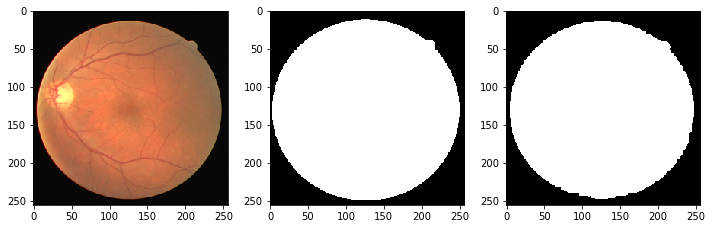

Accuracy= 0.97187805 Precision= 1.0 Recall= 0.96003294 MeanIoU= 0.93668437 DiceCoefficient= 0.9540622684871778 HD= 2.23606797749979 MyIoU= 0.8578125000000004 MAE= 0.028121948


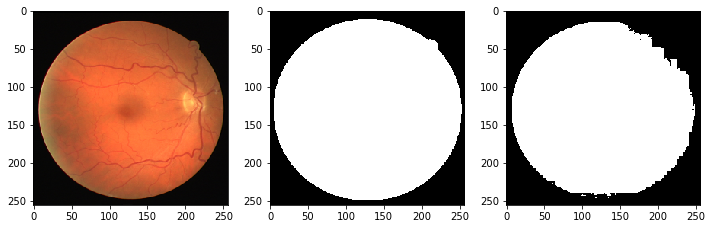

Accuracy= 0.9423828 Precision= 1.0 Recall= 0.9188254 MeanIoU= 0.8765875 DiceCoefficient= 0.9153503983434348 HD= 4.358898943540674 MyIoU= 0.7390625000000006 MAE= 0.057617188


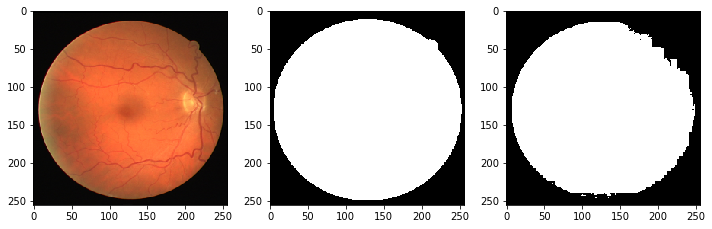

Accuracy= 0.9423828 Precision= 1.0 Recall= 0.9188254 MeanIoU= 0.8765875 DiceCoefficient= 0.9153503983434348 HD= 4.358898943540674 MyIoU= 0.7390625000000006 MAE= 0.057617188


In [33]:
x=0
xx = [0,1,1]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_train[:int(X_train.shape[0]*(1-val_split))][ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_train_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix], preds_train_t[ix])
    x = x+3

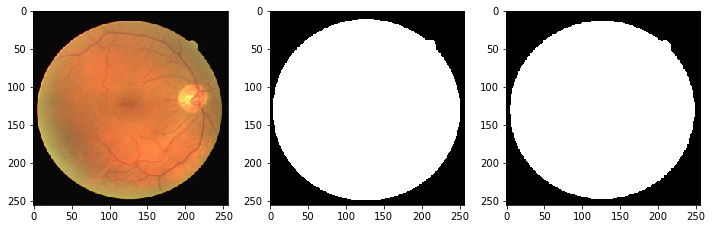

Accuracy= 0.97647095 Precision= 1.0 Recall= 0.9665981 MeanIoU= 0.946432 DiceCoefficient= 0.9609467434784165 HD= 2.8284271247461903 MyIoU= 0.8716796875000002 MAE= 0.023529053


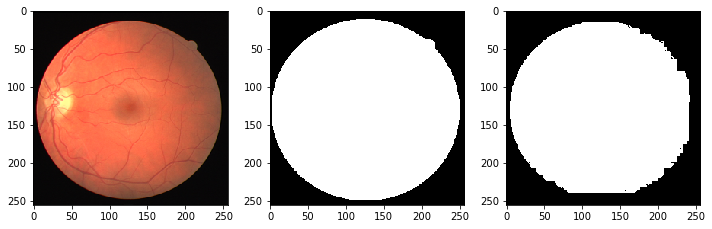

Accuracy= 0.9448395 Precision= 1.0 Recall= 0.9223583 MeanIoU= 0.88116944 DiceCoefficient= 0.9142241973713681 HD= 4.898979485566356 MyIoU= 0.7724609375000002 MAE= 0.055160522


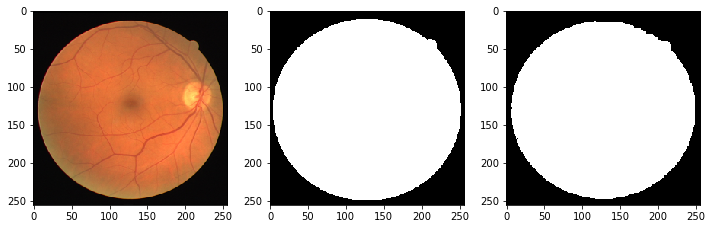

Accuracy= 0.96661377 Precision= 1.0 Recall= 0.9529634 MeanIoU= 0.9248949 DiceCoefficient= 0.9508168424799806 HD= 2.449489742783178 MyIoU= 0.8494140625000005 MAE= 0.03338623


In [34]:
x=0
xx = [16,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_test[ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_test[ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_test_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_test[ix], preds_test_t[ix])
    x = x+3